In [35]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics

In [36]:
trainfile = Path('../data/heart_train.parq').resolve()
testfile = Path('../data/heart_test.parq').resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(PosixPath('/home/azureuser/code/mads-exam-24/data/heart_train.parq'),
 PosixPath('/home/azureuser/code/mads-exam-24/data/heart_test.parq'))

Get the 1D data into a 2D matrix

In [37]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(1))

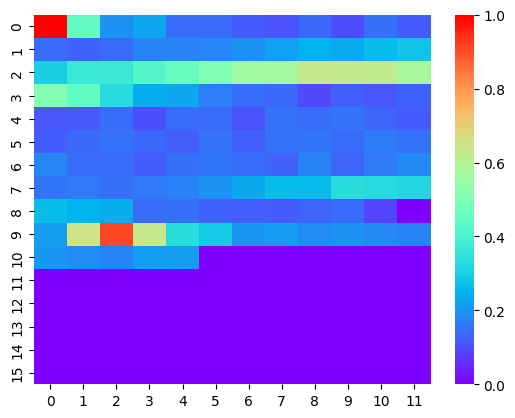

In [38]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [39]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(363, 90)

In [40]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [41]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

In [42]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_layers']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [43]:
from src import models
config = {
    'hidden' : 16,
    'num_layers' : 1,
    'num_classes' : 2, # 5 for big dataset
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-29 10:10:06.653 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-29 10:10:06.654 | INFO     | src.models:__init__:38 - Input linear: 768


torch.Size([32, 2])

In [44]:
from src import models
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
config = {
    'hidden' : 32,
    'num_layers' : 3,
    'num_classes' : 5, # 5 for big dataset
    'dropout_rate': 0.1,
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-29 10:10:06.679 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-29 10:10:06.680 | INFO     | src.models:__init__:38 - Input linear: 1536


torch.Size([32, 5])

In [45]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [46]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [47]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/1', creation_time=1718732376163, experiment_id='1', last_update_time=1718732376163, lifecycle_stage='active', name='2D conv model', tags={}>

In [48]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

 #   trainer = Trainer(
        # model=model,
        # settings=settings,
        # loss_fn=loss_fn,
        # optimizer=torch.optim.Adam,
        # traindataloader=trainstreamer.stream(),
        # validdataloader=teststreamer.stream(),
        # scheduler=None,
       # )
    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2024-06-29 10:10:06.887 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D/20240629-101006
100%|██████████| 363/363 [00:07<00:00, 50.51it/s]
2024-06-29 10:10:15.328 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5611 test 0.4922 metric ['0.7375', '0.7375', '0.6748', '0.7375', '0.6912']
100%|██████████| 363/363 [00:06<00:00, 51.99it/s]
2024-06-29 10:10:23.543 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3804 test 0.2811 metric ['0.8743', '0.8743', '0.8468', '0.8743', '0.8681']
100%|██████████| 363/363 [00:07<00:00, 51.53it/s]
2024-06-29 10:10:31.816 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2409 test 0.1729 metric ['0.9247', '0.9247', '0.9055', '0.9247', '0.9241']
100%|██████████| 363/363 [00:10<00:00, 35.36it/s]
2024-06-29 10:10:43.322 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1720 test 0.1241 metric ['0.9517', '0.9517', '0.9364', '0.9517', '0.9353']
100%|██████████| 363/363 [00:23<00:00, 15.18it/s]
2

In [49]:
model1 = model

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

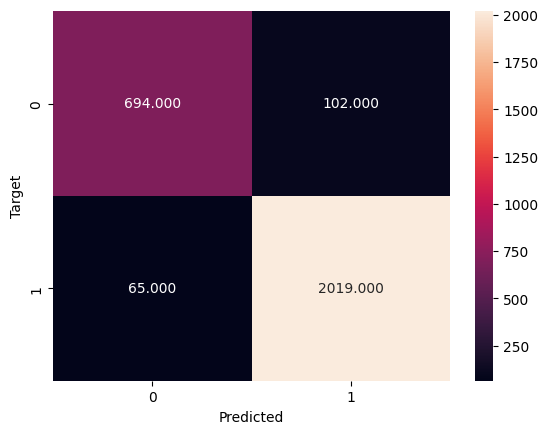

In [50]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

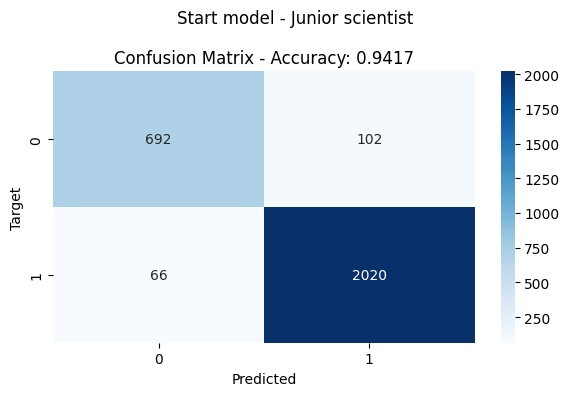

In [51]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_confusion_matrix(model, teststreamer):
    y_true = []
    y_pred = []

    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)
        yhat = model(X)
        yhat = yhat.argmax(dim=1).cpu().tolist()  # Convert to list
        y_pred.extend(yhat)
        y_true.extend(y.cpu().tolist())

    cfm = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix
    acc = accuracy_score(y_true, y_pred)  # Calculate accuracy

    return cfm, acc

# Example usage:
# Assuming you have one model and its corresponding teststreamer
model = model1  # Trained model
teststreamer = teststreamer  # Test streamer

# Evaluate confusion matrix and accuracy for the model
cfm, acc = evaluate_confusion_matrix(model, teststreamer)

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Accuracy: {acc:.4f}")
plt.suptitle("Start model - Junior scientist")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.tight_layout()
plt.savefig("confusion_matrix_with_accuracy.png")
plt.show()

Update model to 6 convolutional layers including Max pooling and add a dropout layer at the end. 

In [52]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),  # Batch normalization added
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),  # Batch normalization added
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling added
        )
        self.dropout = nn.Dropout(p=0.25)  # Dropout layer added

    def forward(self, x):
        return self.dropout(self.conv(x))

In [53]:
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_layers'] - 1):  # Adjusted for 6 convolutional layers
            self.convolutions.extend([ConvBlock(hidden, hidden)])

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8 * 6) * hidden, hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Second dropout layer added
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [54]:
from src import models
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
config = {
    'hidden' : 16,
    'num_layers' : 6,
    'num_classes' : 2, # 5 for big dataset
    'dropout_rate': 0.25,
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-29 10:11:14.785 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-29 10:11:14.786 | INFO     | src.models:__init__:38 - Input linear: 768


torch.Size([32, 2])

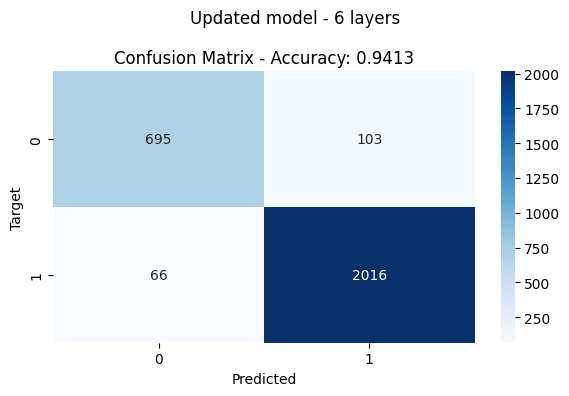

In [55]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_confusion_matrix(model, teststreamer):
    y_true = []
    y_pred = []

    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)
        yhat = model(X)
        yhat = yhat.argmax(dim=1).cpu().tolist()  # Convert to list
        y_pred.extend(yhat)
        y_true.extend(y.cpu().tolist())

    cfm = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix
    acc = accuracy_score(y_true, y_pred)  # Calculate accuracy

    return cfm, acc

# Example usage:
# Assuming you have one model and its corresponding teststreamer
model = model1  # Trained model
teststreamer = teststreamer  # Test streamer

# Evaluate confusion matrix and accuracy for the model
cfm, acc = evaluate_confusion_matrix(model, teststreamer)

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Accuracy: {acc:.4f}")
plt.suptitle("Updated model - 6 layers")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.tight_layout()
plt.savefig("confusion_matrix_with_accuracy_2.png")
plt.show()